In [28]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(ggplot2)
  library(readr)
  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
# load data
data <- prepare_pancreas_sc_spatial()
df <- data[[1]]
cell_annot <- data[[2]]
so_rna <- data[[3]]

Normalizing layer: counts



In [4]:
base_dir <- CachePath('pancreas_scaled_dat4/')

k_joint <- c(5,15,20,30)
k_ct <- c(5)

In [5]:
# load NMF and CRF results
res <- load_nmf_crf_multi(k_joint, k_ct, base_dir)
all_nmf <- res[[1]]
crf_all <- res[[2]]

In [6]:
# load saved enrichment results
enr_res_all <- readRDS(file=paste0(base_dir,'enrich_results.rds'))

In [7]:
# load and extract bridge results
all_ctypes <- unique(cell_annot$celltype)
bridge_res_all <- extract_bridge_multi(all_nmf,all_ctypes=all_ctypes,
                                       dir=base_dir,bridge_pthresh=.1,
                                       bridge_adj_pvals=FALSE)

In [8]:
fp_checks <- check_fp_multi(df,cell_annot,crf_all,enr_res_all=enr_res_all,
                            bridge_res_all=bridge_res_all,
                            do_clean=TRUE,knn_k=25,median_thresh=.2)
annot_res_all <- fp_checks[[1]]
orig_nms_all <- fp_checks[[2]]

In [9]:
# compute cell adj mat for scores calculation
df$cell_type <- df$celltype
sc_ctypes <- unique(so_rna$cell_type)
df_ct_match <- df[df$cell_type %in% sc_ctypes,]
cell_adj_df <- estimate_cell_adjacency(df_ct_match, random.shift=1e-2, n.cores=10)

In [10]:
# now to get genes to exclude based on comparing gene-gene correlations across datasets
so_spatial <- get_counts_meta_seurat(df)
so_spatial <- NormalizeData(so_spatial)
common_genes <- intersect(rownames(so_rna), rownames(so_spatial))
length(common_genes)
so_spatial %<>% subset(features=common_genes)
so_rna %<>% subset(features=common_genes)
cor_cors <- estimate_correlation_preservation(so_spatial[['RNA']]$data, so_rna[['RNA']]$data)

Normalizing layer: counts



[1] 377

In [11]:
dbl_score_params <- list(
  signal_thres=0.5,
  exclude_genes=names(cor_cors)[cor_cors<.025],
  p.c=.25,
  min.expr.frac=0.05,
  exclude.cell.types=NULL,
  max.prob.high=0.1
)

In [20]:
devtools::load_all()

ℹ Loading cellAdmixNotebooks


In [21]:
# identify genes to exclude which likely have strong background signal
ct_both <- intersect(sc_ctypes,unique(cell_annot$celltype))
cells_keep <- colnames(so_rna)[so_rna$cell_type %in% ct_both]
so_rna_sub <- subset(so_rna,cells=cells_keep)

df_sub <- df[df$celltype %in% ct_both,]
bg_cl_fracs <- get_bg_cl_fracs(dbl_score_params,df_sub,so_rna_sub,cell_adj_df,n_samp=1000,n.cores=20)

Normalizing layer: counts



In [22]:
frac_cutoff <- .01
more_g_exclude <- lapply(1:length(bg_cl_fracs),function(i) {
  x <- bg_cl_fracs[[i]]
  ct <- names(bg_cl_fracs)[i]
  g_rm <- names(x)[x<frac_cutoff]
  return(g_rm)
})

names(more_g_exclude) <- names(bg_cl_fracs)
more_g_exclude$all <- dbl_score_params$exclude_genes
dbl_score_params$exclude_genes = unique(unlist(more_g_exclude))

# checking how many got removed from each ctype
for (i in 1:length(bg_cl_fracs)) {
  x <- bg_cl_fracs[[i]]
  x_orig <- length(x)
  x <- names(x)
  x <- x[!(x %in% dbl_score_params$exclude_genes)]
  print(paste0('Fraction ME genes remaining in ',names(bg_cl_fracs)[i],':',round(length(x)/x_orig,3)))
}

[1] "Fraction ME genes remaining in Stellate:0.424"
[1] "Fraction ME genes remaining in Endothelial:0.609"
[1] "Fraction ME genes remaining in Macrophage:0.556"
[1] "Fraction ME genes remaining in Ductal:0.632"
[1] "Fraction ME genes remaining in Alpha-Beta-Delta-Gamma:0.633"
[1] "Fraction ME genes remaining in Acinar:0.609"


In [23]:
# compute admixture probability scores
scores_final_df <- get_scores_multi(annot_res_all,orig_nms_all,dbl_score_params,
                                    df,so_rna,crf_all,cell_adj_df,n.cores=18)

Normalizing layer: counts



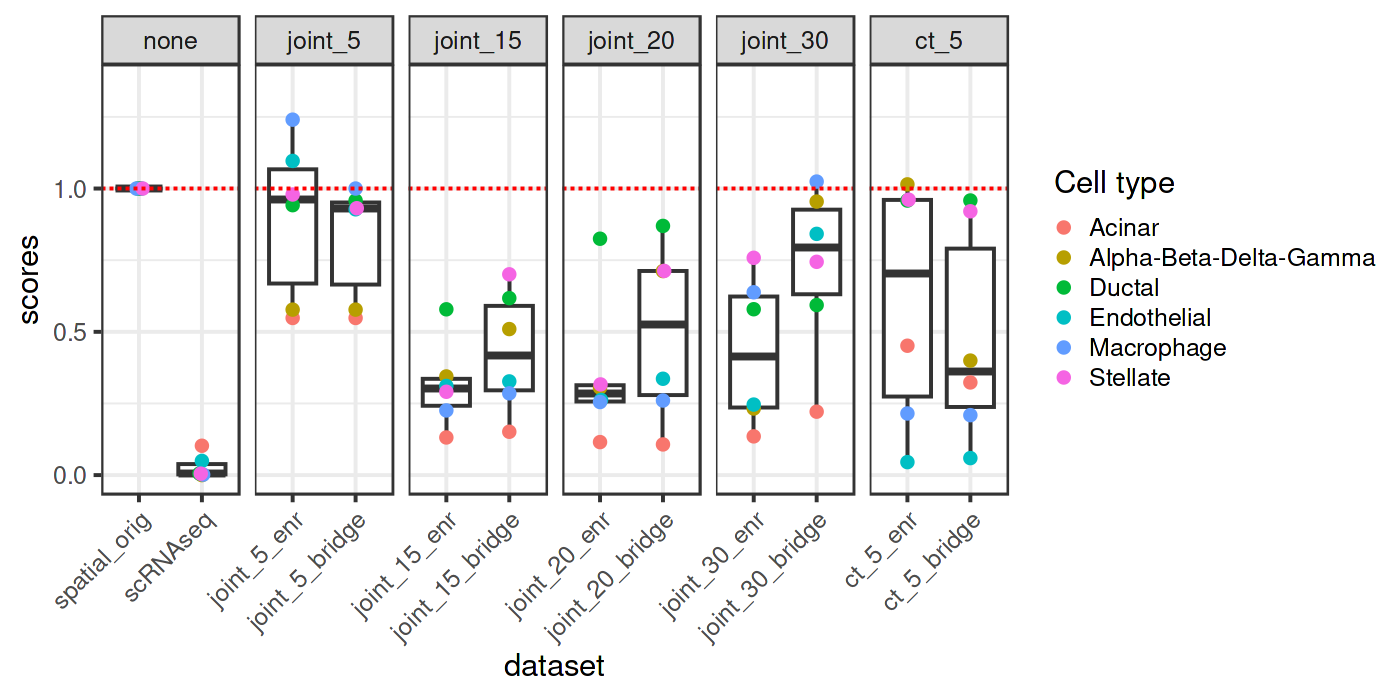

In [24]:
options(repr.plot.width = 7, repr.plot.height = 3.5, repr.plot.res = 200)

# p <- plot_ct_av_norm_scores(scores_final_df,trim_level=.075,min_mean_thresh = 1e-6)
p <- plot_ct_av_norm_scores(scores_final_df,trim_level=.1,min_mean_thresh = 1e-3)
p

In [26]:
res_nm <- 'joint_15_bridge'
res_nm_splt <- strsplit(res_nm,split='_')[[1]]
f_rm <- annot_res_all[[res_nm]]
crf_res <- crf_all[[paste0(res_nm_splt[[1]],'_',res_nm_splt[[2]])]]
scores_orig <- scores_final_df[scores_final_df$dataset=='spatial_orig',]
scores_cln <- scores_final_df[scores_final_df$dataset==res_nm,]

plts <- plot_cell_score_ratios(
  scores_orig, scores_cln, f_rm, df, crf_res, upper.lim=1.5, min.mean.thresh=1e-3
)

Picking joint bandwidth of 0.0855



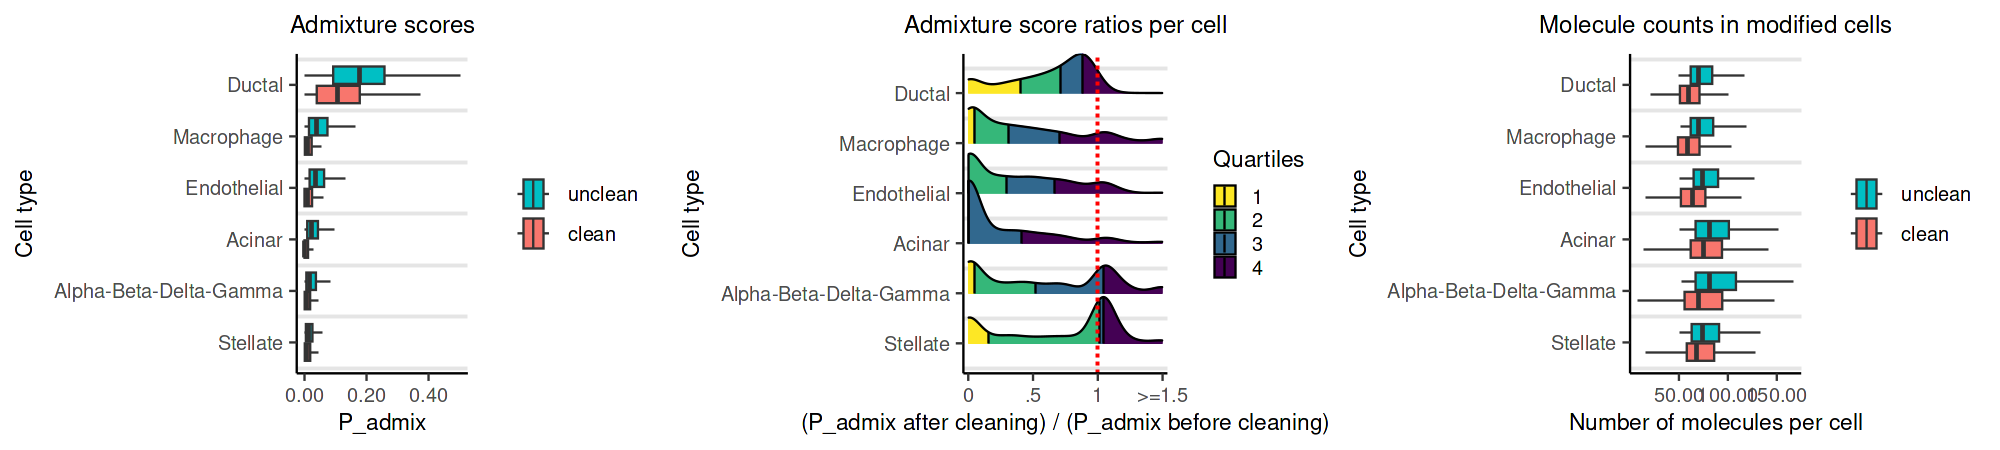

In [29]:
options(repr.plot.width = 10, repr.plot.height = 2.25, repr.plot.res = 200)
fig <- plot_grid(plotlist=plts[c(1,2,4)],nrow=1,align='h')
fig

In [31]:
write_rds(plts[c(1,2,4)], CachePath("panc_cell_score_ratios2.rds"))

In [39]:
# saving an original counts version of the data
so_spatial_orig <- get_counts_meta_seurat(df,normalize=TRUE)
write_rds(so_spatial_orig, paste0(base_dir, 'so_spatial_orig.rds'))

Normalizing layer: counts



In [40]:
# saving a cleaned counts version of the data
k <- 15
f_rm <- annot_res_all[[paste0('joint_',k,'_bridge')]]

# clean the df
df$factor <- crf_res[,1]
df_cln <- df[!(paste(df$factor, df$celltype, sep = "_") %in% f_rm), ]

# make and save a counts version of df_cln
so_spatial_cln <- get_counts_meta_seurat(df_cln,normalize=TRUE)
write_rds(so_spatial_cln, paste0(base_dir, 'so_spatial_cln_', k, '_full.rds'))

Normalizing layer: counts

